# Time Series Classification

This notebook provides practical notes, runnable code, and concise explanations for learning and experimenting with time series classification (TSC) methods. It covers key algorithms, synthetic data generation, and benchmarking tools for time series classification in Python.

- Topic: Time Series Classification (TSC)
- Goal: Help you understand, implement, and compare TSC algorithms using Python libraries and synthetic datasets.

---

## Overview

Time series classification applies supervised machine learning to labeled temporal data: models learn from examples of different classes and then predict the class of new series. This is essential for tasks like sensor monitoring or financial analysis, where correct, reliable predictions directly affect business decisions.

---

## Problem types / when to use

- Univariate vs multivariate time series
- Single-label classification (one label per series)
- Multi-label or sequence labeling (per-timestep labels)

``** Use time series classification when your input is ordered temporal data and the goal is to predict a discrete class for the sequence.``

---

## Types of time series classification

Below is a concise list of common classification types. Each line links to a short, detailed description further down.

1. [Distance-Based Approaches (The Baseline)](#distance-based) 
    * **Concept:** Measures similarity between whole series (Global alignment).
    * **Key Algorithms:** k-Nearest Neighbors (KNN) with **Dynamic Time Warping (DTW)**.
    * **Key Tech:** Pruning with **LB_Keogh** for speed optimization.
    * **Best for:** Small datasets, series with phase shifts/time warping.
2. [Shapelet-Based Approaches (The Interpretable)](#shapelet) 
    * **Concept:** Focuses on finding discriminative **local subsequences** (e.g., a specific "bump" or "spike").
    * **Key Algorithms:** **Learning Shapelets**.
    * **Best for:** When you need to explain *why* (Interpretability) and when noise is high in non-discriminative regions.
3. [Model Ensembles (The SOTA for Accuracy)](#model-ensembles) 
    * **Concept:** Combines multiple diverse classifiers (Shape, Dictionary, Frequency, etc.) and uses voting/weighting to decide.
    * **Key Algorithms:** **HIVE-COTE** (The "Meta-Ensemble").
    * **Best for:** Small-to-medium datasets where **Accuracy is the only priority** (regardless of speed).
4. [Dictionary-Based Approaches (The Fast & Modern)](#dictionary-approach) 
    * **Concept:** Counts the frequency of patterns (like "Bag-of-Words" in text).
    * **Key Algorithms:** **ROCKET** (RandOm Convolutional KErnel Transform).
    * **Best for:** Large datasets, needing high accuracy and speed.
5. [Interval-Based Approaches (The Statistical)](#interval-based-approach)
    * **Concept:** Splits time series into intervals and calculates statistics (Mean, Std, Slope) for each.
    * **Key Algorithms:** **Time Series Forest (TSF)**.
    * **Best for:** When "where" an event happens matters (fixed locations).
6. [Deep Learning (The SOTAFor Big Data)](#deep-learning) 
    * **Concept:** Uses Neural Networks to automatically learn hierarchical features from raw data.
    * **Key Algorithms:** **1D-CNN** (Convolutional Neural Networks), ResNet, InceptionTime.
    * **Best for:** Large datasets, complex non-linear patterns, raw data handling.


---

### Distance-based

Distance-based methods use a numeric **distance** to quantify how similar two time series are. The smaller the distance, the more similar the series. Common distance measures used in ML include **Euclidean**, **Manhattan**, **Minkowski**, and **Hamming** distances — but for time series we often need measures that tolerate time shifts and local misalignments, which is where **Dynamic Time Warping (DTW)** shines.

How distance-based classification works (typical **k‑NN** flow):

- **Normalize** series (usually **z-normalization**) to remove scale/offset differences.
- Compute **distances** between the test series and every training series using a chosen metric.
- Select the **k** training series with the smallest distances.
- Assign the test series the majority class among those **k** neighbors (**k=1** gives **1‑NN**).

Notes on distance metrics and algorithms:

- **Euclidean** / **Manhattan** / **Minkowski**: simple pointwise distances; efficient but sensitive to small time shifts.

- **Hamming**: for discrete/symbolic sequences; counts mismatches at aligned positions.

- **Kernel / SVM** relation: kernel methods (e.g., **SVM**) can incorporate similarity information — a kernel can be built from a distance or similarity measure so that the classifier uses pairwise similarities (think of an **SVM** with a custom kernel derived from a distance matrix).

Why **DTW** is special for time series:

  - **DTW** aligns two sequences by warping the time axis to find the minimum cumulative distance (warping path) between them; this handles local speed/phase differences (e.g., the same pattern occurs slightly earlier/later).

  - **DTW** computes a cost matrix and a minimal-cost path through it. Complexity is **O(n\*m)** for series lengths n and m; common speedups include limiting the **warping window** (Sakoe–Chiba / Itakura constraints) and using lower bounds (**LB_Keogh**) to prune comparisons.

  - In practice, **DTW + 1‑NN** has been a strong baseline for many TSC tasks and is commonly used in benchmarks.
  



*Example:*

  * Comparing two people walking:
    - **Sequence A (Person A)**: [Walk, Rest, Walk, Rest]
    - **Sequence B (Person B)**: [Rest, Walk, Rest, Walk]
    - Essentially, both people exhibit the same behavior (2 steps of walking, 2 beats of resting), but Person B simply starts 1 beat later.

  1. **Using Euclidean Distance (Pointwise Comparison):**
    - Euclidean compares rigidly, point-by-point:
      - T1: (A Walk) vs (B Rest) → Different!
      - T2: (A Rest) vs (B Walk) → Different!
      - T3: (A Walk) vs (B Rest) → Different!
      - T4: (A Rest) vs (B Walk) → Different!
    - **Conclusion by Euclidean**: These sequences are completely different (large distance).

  2. **Using Hamming Distance (Pointwise Comparison):**

      * Hamming distance rigidly counts the mismatches at each corresponding position:

        * **T1:** (A `Walk`) vs (B `Rest`) $\rightarrow$ Mismatch! (Count = 1)
        * **T2:** (A `Rest`) vs (B `Walk`) $\rightarrow$ Mismatch! (Count = 2)
        * **T3:** (A `Walk`) vs (B `Rest`) $\rightarrow$ Mismatch! (Count = 3)
        * **T4:** (A `Rest`) vs (B `Walk`) $\rightarrow$ Mismatch! (Count = 4)

      - **Conclusion by Hamming:** These sequences are **completely different**. The Hamming distance is 4, which is the maximum possible distance for sequences of this length, implying zero similarity.

  3. **Using DTW (Dynamic Time Warping):**
    - DTW is smarter. It "warps" the time axis to find the best alignment:
      - (A Walk at T1) aligns with (B Walk at T2).
      - (A Rest at T2) aligns with (B Rest at T3).
      - (A Walk at T3) aligns with (B Walk at T4).
    - **Conclusion by DTW**: These sequences are very similar, just slightly misaligned (phase-shifted).

  This example highlights why DTW is particularly effective for time series data, as it can handle local shifts in time and still identify underlying similarities.

### 📊 Bảng so sánh các phương pháp đo lường

| Phương pháp | Loại dữ liệu chính | Cách hoạt động (Đơn giản) | Điểm mạnh / Điểm yếu |
| :--- | :--- | :--- | :--- |
| **Euclidean / Manhattan** | Dữ liệu số, liên tục | So sánh **1-đối-1** tại *cùng một thời điểm*. (Điểm `T1` của A vs. Điểm `T1` của B) | **(+)** Rất nhanh, hiệu quả.<br> **(-)** **Rất nhạy cảm** nếu dữ liệu bị lệch (shift) dù chỉ một chút. |
| **Hamming** | Dữ liệu rời rạc, ký hiệu | Đếm số lượng vị trí mà hai chuỗi *không khớp* nhau. (Ví dụ: `A,B,C` vs `A,B,D` có 1 điểm không khớp) | **(+)** Tốt cho dữ liệu dạng ký tự, gen, v.v.<br> **(-)** Không dùng được cho dữ liệu số liên tục (như nhiệt độ). |
| **DTW (Dynamic Time Warping)** | Dữ liệu số, liên tục | So sánh **1-đối-nhiều**. Nó "co giãn" thời gian để tìm cách căn chỉnh (align) tốt nhất. | **(+)** **Cực kỳ tốt** cho các chuỗi bị lệch pha/tốc độ.<br> **(-)** Tính toán chậm và tốn kém hơn (phức tạp O(n*m)). |
| **Kernel (dùng trong SVM)** | Bất kỳ (tùy kernel) | Đây là một *mô hình*, không phải phép đo. Nó dùng một "kernel" (có thể dựa trên DTW) để biến đổi dữ liệu. | **(+)** Rất mạnh mẽ để phân loại.<br> **(-)** Phức tạp hơn, không chỉ là một phép đo khoảng cách. |

Practical tips and pitfalls:

- Always **z-normalize** series before **DTW** or **Euclidean** comparisons — otherwise scale dominates the distance.

    * Z-normalization is a preprocessing step that standardizes a time series to have a mean of 0 and a standard deviation of 1. This allows algorithms like DTW to compare data based on shape rather than differences in scale or offset.
    $$z = \frac{x - \mu}{\sigma}$$

            **example:
                x1  x2  x3      x'1    x'2  x'3
            A: [26, 27, 26] -> [-0.33, 0.667, -0.33]
            B: [36, 37, 36] -> [-0.33, 0.667, -0.33]

                                        A     B
            * μ = (x1 + x2 + x3)/3 = [26.33,36,33]
            * σ = 1

- Use a **warping window** (e.g., 5–10% of series length) to avoid pathological warpings and speed up computation.

    * A "warping window" (e.g., 10% of series length) is a constraint added to DTW. Instead of calculating the entire $n \times m$ cost matrix, it only computes a small "band" around the diagonal.

        * **Benefit 1 (Speed):** Drastically speeds up computation from $O(n \times m)$ to $O(n \times r)$ (where $r$ is the window size).
        * **Benefit 2 (Accuracy):** Prevents "pathological warping" (unrealistic stretching/compressing of time) by forcing matches to stay relatively close. (ex: $|i - j| \le r$)

- For large datasets, compute and cache pairwise distances or use approximate methods / lower bounds (**LB_Keogh**) to prune.

    * Pruning is a "skip" strategy used to speed up search algorithms like KNN. Instead of performing the **slow, expensive** distance calculation (like DTW) for *every* item in the dataset, it uses a **fast, simpler** "proxy" calculation (a Lower Bound) to quickly eliminate candidates.

    * The logic is: If the *fast proxy distance* is already worse than the best match you've found so far, you can **"prune" (safely discard)** that candidate without ever running the slow calculation.

    * Key Advantages

        * **Massive Speedup:** It dramatically reduces the total number of expensive calculations required, often by over 99%. This makes KNN-DTW feasible on large datasets that would otherwise be computationally impossible.
        * **Guaranteed Accuracy:** When used correctly (with a true lower bound), pruning is an **exact** optimization, *not* an approximation. The final result (the nearest neighbor) is **guaranteed to be the same** as if you had run the full, slow brute-force search.
        
                Q = [1, 3, 2, 4]
                C = [3, 4, 1, 5]
                r = 1
            
        |  i | C[i] | L[i] = min(Q[i - r, i + r]) | U[i] = max(Q[i - r, i + r]) | Kiểm tra | Phí phạt (Cost) |
        | :--- | :--- | :--- | :--- | :--- | :--- |
        | **0** | **3** | `min(Q[0,1]) = min(1,3)` = **1** | `max(Q[0,1]) = max(1,3)` = **3** | `1 <= 3 <= 3` (Trong hầm) | 0 |
        | **1** | **4** | `min(Q[0..2]) = min(1,3,2)` = **1** | `max(Q[0..2]) = max(1,3,2)` = **3** | `4 > 3` (Vọt trần) | `(4 - 3)² = 1` |
        | **2** | **1** | `min(Q[1..3]) = min(3,2,4)` = **2** | `max(Q[1..3]) = max(3,2,4)` = **4** | `1 < 2` (Đâm sàn) | `(2 - 1)² = 1` |
        | **3** | **5** | `min(Q[2,3]) = min(2,4)` = **2** | `max(Q[2,3]) = max(2,4)` = **4** | `5 > 4` (Vọt trần) | `(5 - 4)² = 1` |
        | **Tổng** | | | | **Tổng Khoảng cách (LB\_Keogh)** | **0 + 1 + 1 + 1 = 3** |

- Consider **derivative DTW** or **weighted DTW** variants if amplitude vs. shape matters.

  1. Derivative DTW (DDTW)

  **Idea:**
Instead of comparing the absolute values `A[i]` vs. `B[j]`, this algorithm compares their *derivatives* (estimated slopes) at those points (e.g., `(A[i] - A[i-1])` vs. `(B[j] - B[j-1])`).

  **What it Solves:**
It completely ignores differences in "offset" (baseline shift). The two series `[1, 2, 3]` and `[101, 102, 103]` would have a DDTW distance of nearly 0, as they both have the same *slope* (a constant increase of 1).

  **When to Use:**
When **shape** and **trend** are the only things that matter, and the absolute amplitude (value) is irrelevant or misleading. (e.g., gesture recognition, signature matching).

  2. Weighted DTW (WDTW)

  **Idea:**
  This is standard DTW, but it adds a "weight" to the distance calculation at each point, often based on amplitude. The formula becomes: `Cost = Weight(i, j) * (A[i] - B[j])²`.

  **What it Solves:**
  It addresses the problem that "not all points are equally important." It heavily penalizes misalignments at peaks or valleys and cares less about errors along the flat baseline.

  **When to Use:**
  When **both shape and amplitude matter**, and you specifically want to ensure that high-amplitude events (like ECG peaks, stock price spikes) are aligned correctly.

Small runnable example (**DTW + 1‑NN** using `tslearn` + scikit-learn):

In [ ]:
pip install numpy tslearn matplotlib scikit-learn h5py 

Prediction Class: perfect sin
Nearest Neighbor Index: 0 (Label: perfect sin)


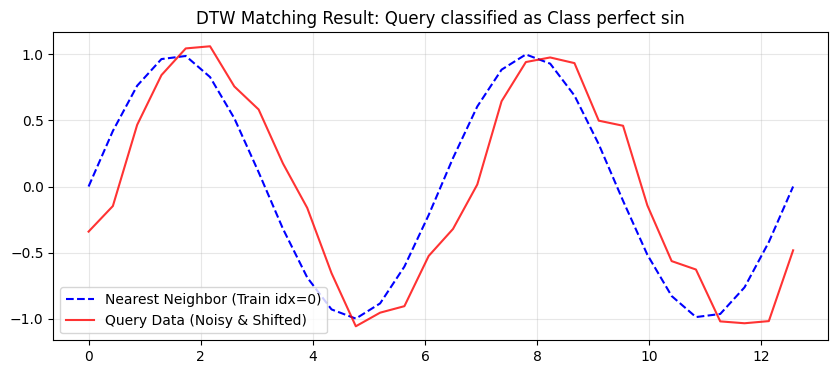

In [22]:
# Install libraries if missing:
# !pip install numpy tslearn matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

# ==========================================
# 1. DATA PREPARATION (Giả lập dữ liệu)
# ==========================================

# Cấu hình dữ liệu
N_POINTS = 30           # Độ phân giải: 30 điểm dữ liệu/mẫu
CYCLES = 4 * np.pi      # 4*pi = 2 chu kỳ sóng đầy đủ (vì 1 chu kỳ = 2*pi)
                        # -> Giúp tạo dữ liệu đủ phức tạp để test độ khớp

# Tạo trục thời gian
t = np.linspace(0, CYCLES, N_POINTS)

# --- Training Set ---
# Tạo 3 mẫu: 2 mẫu hình SIN (Class 0) và 1 mẫu đường thẳng (Class 1)
X_train_raw = [
    np.sin(t),                 # Mẫu 0: Sin chuẩn
    np.sin(t + 0.5),           # Mẫu 1: Sin lệch pha (Shifted left). DTW xử lý tốt cái này.
    np.linspace(0, 0, N_POINTS)# Mẫu 2: Đường thẳng (Flat line)
]
y_train = ["perfect_sin", "shifted_sin", "flat_line"]            # Nhãn tương ứng cho các mẫu trên

# --- Query (Test) Data ---
# Tạo một mẫu Sin mới, bị lệch pha và có nhiễu
# - (t - 0.5): Lệch pha ngược chiều so với mẫu 1 -> Thử thách DTW co giãn
# - np.random.normal(...): Thêm nhiễu Gaussian để mô phỏng cảm biến thực tế (không bao giờ mượt 100%)
query_raw = np.sin(t - 0.5) + np.random.normal(0, 0.1, N_POINTS)

# Format lại dữ liệu theo chuẩn của tslearn (n_samples, sz, d)
X_train = to_time_series_dataset(X_train_raw)
X_query = to_time_series_dataset([query_raw])

# ==========================================
# 2. MODELING (Cách Dev thường làm)
# ==========================================
# Sử dụng KNeighborsTimeSeriesClassifier của tslearn.
# Đây là wrapper tối ưu, hỗ trợ metric="dtw" ngay lập tức.
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")

# Train (Lưu dữ liệu vào memory)
knn_clf.fit(X_train, y_train)

# Predict
prediction = knn_clf.predict(X_query)

# ==========================================
# 3. VISUALIZATION & LOGGING
# ==========================================
# Lấy ra index của hàng xóm gần nhất để verify
neighbor_idx = knn_clf.kneighbors(X_query, return_distance=False)[0][0]

print(f"Prediction Class: {prediction[0]}")
print(f"Nearest Neighbor Index: {neighbor_idx} (Label: {y_train[neighbor_idx]})")

# Vẽ hình so sánh
plt.figure(figsize=(10, 4))
plt.plot(t, X_train[neighbor_idx].ravel(), 'b--', label=f"Nearest Neighbor (Train idx={neighbor_idx})")
plt.plot(t, query_raw, 'r-', alpha=0.8, label="Query Data (Noisy & Shifted)")
plt.title(f"DTW Matching Result: Query classified as Class {prediction[0]}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

When to choose distance-based methods:

  * Distance-based approaches (typically **k-Nearest Neighbors**) classify time series by measuring the global similarity between a test sample and labeled training samples.

    * **Global Similarity Focus:** Use when the class is defined by the **overall shape or pattern** of the entire series, rather than specific small sub-patterns (shapelets) or complex abstract features.
    * **Low Data Regimes:** Highly effective when training data is scarce, as there are no complex parameters to learn (unlike Deep Learning).
    * **Interpretability:** Ideal when you need to explain *why* a classification was made by showing the "nearest neighbors" (similar historical examples).
    * **"Lazy" Learning:** Useful when you need to add new data to the training set frequently without retraining a model (since there is no training phase).

  * Metric Selection Guide:
    * **Euclidean:** Use for fixed-length, perfectly aligned continuous data (fastest).
    * **DTW:** Use for continuous data with phase shifts or speed variations (most accurate).
    * **Hamming / Edit Distance:** Use for **discrete** or symbolic sequences (e.g., DNA, text, log events).

#### *End of Distance-based method* 
---

### Shapelet

#### 1. How it works

Unlike distance-based methods that compare the _entire_ time series (like DTW or Euclidean), this approach focuses on **local subsequences**.

1.  **Discovery:** The algorithm scans the training data to find **subsequences** (short segments) that best discriminate between classes. These discriminative subsequences are called **Shapelets**.
2.  **Transformation:**
    - For a new time series, the algorithm "slides" the Shapelet along the entire series.
    - It calculates the Euclidean distance at every position.
    - The **Minimum Distance** found is kept.
3.  **Classification:** This "minimum distance" value becomes a new feature. These features are then fed into a standard classifier (like a Linear Classifier or Random Forest) to predict the class.

#### 2. Note

- `Shapelet Transform: This process converts raw Time Series data into a vector of distances. For example, if the model learns 5 shapelets, each time series is transformed into a vector of 5 numbers (the distances to those 5 shapelets).`

##### The Concept: Dimensionality Reduction
Instead of analyzing the entire raw time series (which might be hundreds of points long), the algorithm summarizes the series based on **how well it matches** a specific set of learned patterns (Shapelets).

##### The Metaphor: A Medical Checklist
Imagine the Time Series is a **Patient** and the Shapelets are a list of **5 Symptoms** (e.g., Cough, Fever, Rash, etc.).
Instead of recording the patient's entire biological history, a doctor simply notes the presence or absence of these 5 symptoms.

* **Raw Data:** The patient's history (Complex & Long).
* **Shapelets:** The 5 specific symptoms to look for.
* **Vector of Distances:** The checklist results.

##### Technical Step-by-Step
Assume we have a raw Time Series $T$ (length 100) and the model has learned **5 Shapelets** ($S_1$ to $S_5$).

1.  **Scan & Measure:** The algorithm slides $S_1$ across $T$ to find the *best local match* (minimum Euclidean distance).
    * *Result:* It finds a very similar segment. Distance = **0.5**.
2.  **Repeat:** It does the same for $S_2$.
    * *Result:* It finds no similar segment. Distance = **100.2**.
3.  **Compile:** It repeats this for all 5 shapelets.

##### The Transformation Result
The data is transformed from a temporal sequence into a simple feature vector (a list of coordinates):

* **Input (Raw Time Series):** `[12, 15, 11, 20, ..., 5]` (Length: 100)
* **Output (Feature Vector):** `[0.5, 100.2, 12.1, 3.4, 88.0]` (Length: 5)

##### Why do this?
The resulting vector acts as a new set of coordinates for the data:
* **Low Value (0.5):** Indicates the series **contains** the pattern $S_1$.
* **High Value (100.2):** Indicates the series **does not contain** the pattern $S_2$.

**Benefit:** This simple vector of 5 numbers can now be fed into standard, efficient machine learning classifiers (like Random Forest, SVM, or Logistic Regression), which handle vectors well but cannot handle raw time series data directly.
    



- `A Shapelet does not need to be the same length as the original time series; it is typically much shorter.`

#### 3. Why it is special

- **Interpretability:** This is its strongest advantage. You can point to a specific segment on a plot and say: _"This series is classified as 'Heart Disease' because it contains this specific pattern (shapelet) that matches the disease signature."_ Deep Learning or global DTW cannot provide this level of granular explanation.
- **Noise Resistance:** Because it looks for the "best local match," it effectively ignores noise or irrelevant distortions in the rest of the time series.
    ### ❓ Clarification: Is Euclidean Distance sensitive to noise?

    **User Doubt:** Since Shapelets use Euclidean distance (point-to-point), shouldn't they be highly sensitive to noise?

    **Answer:**
    Yes, Euclidean distance is sensitive to pointwise noise. However, the "Noise Resistance" of Shapelets refers to **Global Resistance**, not Pointwise Resistance.

    1.  **Ignoring "Background" Noise:** The primary strength is the **Minimum Distance** mechanism. If a time series is 90% noise and 10% signal, the algorithm slides the shapelet across. It finds the matching 10% (low distance) and **discards** the high distance values calculated from the 90% noisy background.
        * *Key phrase:* "Ignores distortions in the **rest** of the time series."

    2.  **Handling "Local" Noise:** For noise within the matching segment itself:
        * **Z-Normalization:** Subsequences are typically Z-normalized before comparison, removing amplitude/offset noise.
        * **Shape Dominance:** Unless the noise is so extreme that it destroys the shape (e.g., a spike becomes a flat line), the Euclidean distance of a "noisy match" will still be significantly lower than that of a "non-match."

#### 4. Example

**ECG Diagnosis (Electrocardiogram):**

- **Class A (Normal):** Regular heartbeat.
- **Class B (Pathology):** Mostly regular, but occasionally exhibits a specific **small dip** (e.g., ST-depression) lasting 0.5 seconds.
- **The Shapelet:** The algorithm learns that this specific "dip" shape is the key discriminator.
- **Detection:** When scanning an hour-long ECG, as soon as it finds a segment that matches this "dip" (low distance), it flags the series as pathological, regardless of the rest of the signal.

#### 5. Practical tips and pitfalls

- **Pitfall (Computational Cost):** Finding shapelets using a brute-force search is extremely computationally expensive ($O(N^2 M^4)$).
- **Tip:** Use optimized libraries like `tslearn` which implements **"Learning Shapelets"**. This method learns the shapelets via Gradient Descent (similar to training a neural network) rather than searching for them, which is significantly faster.
- **Tip:** The number of shapelets (`n_shapelets`) and their length (`sz`) are critical hyperparameters that need tuning.

#### 6. When to choose

1.  **Local Features:** When the class is defined by a specific, short event (a spike, a dip, a specific cycle) rather than the global shape.
2.  **Explainability Required:** In fields like healthcare, engineering, or finance where you must explain _why_ a decision was made.
3.  **High Background Noise:** When the majority of the time series is irrelevant noise, and the signal is contained in a small segment.

## 7. Runnable Example

In [ ]:
# Run this cell to install packages required by the shapelet example (cell 17)
# Use %pip to ensure the notebook's environment is used.
# %pip install --upgrade pip
%pip install numpy matplotlib tslearn tensorflow

C:\Users\qwsde\AppData\Roaming\Python\Python313\site-packages\tslearn\shapelets\shapelets.py:492: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/1000


C:\Users\qwsde\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7025
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7025
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7025
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7025
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7024
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6871 - loss: 0.7024
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6870 - loss: 0.7024
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - binary_accuracy: 0.5000 - binary_crossentropy: 0.6870 - loss: 0.7024
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━

C:\Users\qwsde\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


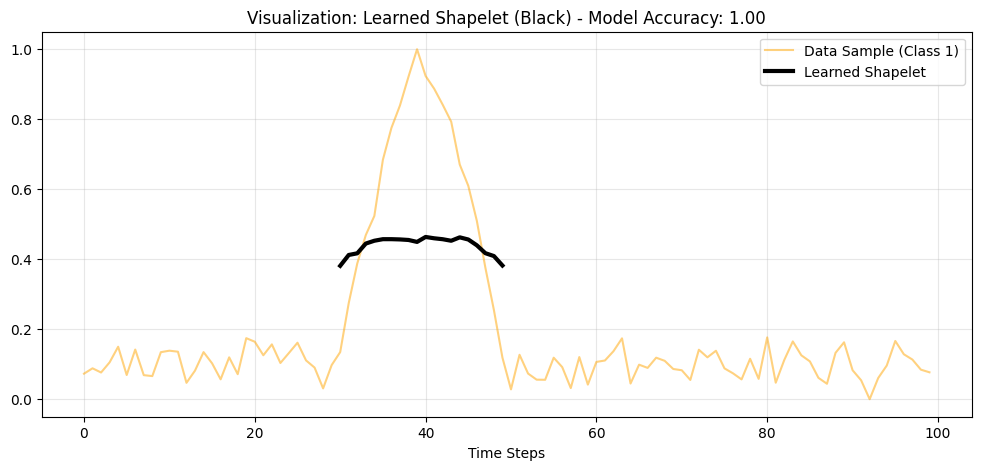

Observation: The black line should now curve to match the 'bump'.


In [4]:
# Requires: pip install tslearn tensorflow
import numpy as np
import matplotlib.pyplot as plt
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax

# ==========================================
# 1. SYNTHETIC DATA GENERATION (Improved)
# ==========================================
np.random.seed(42)
n_samples = 200  # <--- MODIFICATION 1: Increased from 50 to 200 samples
time_steps = 100

X = np.zeros((n_samples, time_steps, 1)) 

    # x => shape: [ 
    #               A1: [ A1,1: [0], A1,2: [0], ..., A1,100: [0] ],
    #               A2: [ A2,1: [0], A2,2: [0], ..., A2,100: [0] ],
    #               ... ,
    #               A200: [ A200,1: [0], A200,2: [0], ... , A200,100: [0] ]
    #             ]
    # shape: time series
    # A1: time series sample 1
    # A1,1: time step 1 of sample 1
    # A1,1,0: feature 0 of time step 1 of sample 1 (univariate => only 1 feature per time step)
            
y = np.zeros(n_samples)

    # y => shape: [ C1, C2, ..., C200 ]
    # Ci: class label of sample i

for i in range(n_samples):
    # Generate background noise
    X[i, :, 0] = np.random.normal(0, 0.1, time_steps)
        # i=0: sample 1 => X[0, :, 0] = [ x0,1,val, x0,2,val, ..., x0,100,val ]
        
    
    if i >= n_samples // 2:  # Second half belongs to Class 1
        y[i] = 1
        # Inject a "Bell-shaped Bump" at a random position
        start = np.random.randint(10, 80) # Ensure the bump fits within the time series
        # This sine wave segment is the "discriminative feature"
        X[i, start:start+20, 0] += np.sin(np.linspace(0, np.pi, 20)) * 2
        # i=150: sample 151 => X[150, x: x+20, 0] = [ x150,1,val, x150,2,val, ..., x150,100,val ]

# Normalize data
scaler = TimeSeriesScalerMinMax()
X = scaler.fit_transform(X)

# ==========================================
# 2. TRAIN LEARNING SHAPELETS MODEL (Tuned)
# ==========================================
# We ask the model to learn exactly 1 shapelet of length 20
shp_clf = LearningShapelets(n_shapelets_per_size={20: 1},
                            max_iter=1000,          # <--- MODIFICATION 2: Increased iterations (give it time to learn)
                            verbose=1,              # Set to 1 to see the loss decreasing
                            scale=False,
                            random_state=42,         
                            weight_regularizer=0.01) # <--- MODIFICATION 3: Reduce regularization to allow "curvy" shapes
shp_clf.fit(X, y)

# ==========================================
# 3. VISUALIZATION
# ==========================================
predicted_locations = shp_clf.locate(X) 

plt.figure(figsize=(12, 5))
plt.title(f"Visualization: Learned Shapelet (Black) - Model Accuracy: {shp_clf.score(X, y):.2f}")

# Dynamic Sample Selection: Find a valid sample from Class 1 to plot
# Instead of hardcoding '30', we find the first index where y == 1
idx_sample = np.where(y == 1)[0][0] 

# Plot the data sample (Orange)
plt.plot(X[idx_sample].ravel(), color='orange', label='Data Sample (Class 1)', alpha=0.5)

# Plot the learned shapelet (Black) at the correct position
learned_shapelet = shp_clf.shapelets_[0]
start_pos = predicted_locations[idx_sample, 0]

if start_pos < time_steps:
    t_range = range(start_pos, start_pos + len(learned_shapelet))
    plt.plot(t_range, learned_shapelet, color='black', linewidth=3, label='Learned Shapelet')

plt.legend()
plt.grid(True, alpha=0.3)
plt.xlabel("Time Steps")
plt.show()

print("Observation: The black line should now curve to match the 'bump'.")



#### *End of Shapelet method* 
---

### Model ensembles

 1. Concept
An ensemble is a collection of multiple classification models. Instead of relying on a single algorithm, the system aggregates the predictions from many models and determines the final class via **Majority Voting**.

 2. The Key Condition: Uncorrelated Errors
For an ensemble to be effective, the individual models must make **different kinds of errors**.
    * **Correlated Errors:** If all models fail on the same data points (e.g., they are too similar), the ensemble is no better than a single model.
    * **Uncorrelated Errors:** If models are diverse (e.g., one looks at shape, one looks at frequency), the mistake of one model can be corrected by the correct votes of others.

 3. HIVE-COTE (Hierarchical Vote Collective of Transformation-based Ensembles)
This is a specific, high-performing algorithm mentioned in the text. It structures the ensemble by **grouping classifiers by type** not **by models**:
    * It combines classifiers from different domains (Distance-based, Shapelet-based, Dictionary-based, etc.).
    * **Mechanism:** Each group produces a prediction, and these "group predictions" are combined for the final result.
    * **Pros:** Extremely high accuracy (often State-of-the-Art) on small/medium datasets.
    * **Cons:** **Poor Scalability.** Because it runs many complex algorithms simultaneously, it is computationally expensive and slow on large datasets.



#### *End of Model ensembles method* 
---

### Dictionary approach

#### 1. How it works
This approach is inspired by the **"Bag-of-Words"** technique used in Natural Language Processing (text classification). It treats a time series not as a sequence of numbers, but as a collection of "words" or "patterns."

1.  **Sliding Window / Convolution:** The algorithm slides a window (or a kernel) across the entire time series.
2.  **Transformation (The "Dictionary"):**
    * **Traditional (Bag-of-Patterns):** Converts numerical segments into symbols (e.g., "High-Low-High" becomes word 'A').
    * **Modern (ROCKET):** Applies thousands of **random convolutional kernels**. For each kernel, it calculates two values: the *maximum response* (how well it matched) and the *proportion of positive values* (frequency).
3.  **Feature Vector:** Instead of caring *when* a pattern happened, it counts *how strongly/frequently* these patterns appeared.
    * *Analogy:* To classify an email as "Spam," we count the occurrence of words like "Free", "Money." We don't care if "Money" appears at the start or end, just that it appears.
4.  **Classification:** The resulting matrix of features is fed into a simple, fast linear classifier (like a Ridge Classifier).

#### 2. Note
* **ROCKET (RandOm Convolutional KErnel Transform):** This is the current state-of-the-art dictionary method. Unlike Deep Learning (CNNs), ROCKET **does not learn** the kernels. It generates thousands of random kernels (random length, weights, dilation) and uses them as-is.
* It transforms a time series of length $T$ into a feature vector of length $2 \times K$ (where $K$ is the number of kernels, typically 10,000).

#### 3. Why it is special
* **Blazing Speed:** Since kernels are random (no gradient descent training) and the classifier is linear, ROCKET is orders of magnitude faster to train than Deep Learning or Shapelets.
* **High Accuracy:** Despite the randomness, the sheer number of kernels captures a vast variety of features (trends, frequencies, shapes), often matching complex ensemble methods like HIVE-COTE.
* **No "Training" Phase for Kernels:** You only train the final linear classifier.

#### 5. Practical tips and pitfalls
* **Tip (Number of Kernels):** The standard is **10,000 kernels**. Linear classifiers handle this high dimensionality very well.
* **Tip (Data Scaling):** Always Z-normalize data before ROCKET, as convolution is sensitive to amplitude scaling.
* **Pitfall (Interpretability):** Unlike Shapelets (where you see the "bump"), ROCKET is a **Black Box**. It tells you "Feature #402 was important," but Feature #402 is a random convolution result, which is hard to explain to a human.
* **Pitfall (Memory):** Transforming massive datasets can consume significant RAM.

#### 6. When to choose
1.  **Large Datasets:** When you have thousands of samples, and DTW or Shapelets are too slow.
2.  **Complex/Abstract Patterns:** When the distinguishing feature isn't a simple visual shape but something abstract (e.g., fuzzy texture, frequency jitter).
3.  **High Accuracy Priority:** When accuracy is more important than explainability.
4.  **Baseline:** ROCKET is the best "first model" to run to set a high performance benchmark.

#### 7. Runnable Example

In [2]:
%pip install numpy scikit-learn sktime

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/36.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/36.3 MB ? eta -:--:--
    --------------------------------------- 0.5/36.3 MB 2.2 MB/s eta 0:00:17
    --------------------------------------- 0.8/36.3 MB 1.8 MB/s eta 0:00:20
   - -------------------------------------- 1.3/36.3 MB 2.1 MB/s eta 0:00:17
   -- ------------------------------------- 1.8/36.3 MB 2.0 MB/s eta 0:00:17
   -- ------------------------------------- 2.4/36.3 MB 2.2 MB/s eta 0:00:16
   -- ------------------------------------- 2.6/36.3 MB 2.2 MB/s eta 0:00:16
   --- ------------------------------------ 3.1/36.3 MB 2.0 MB/s eta 0:00:17
   --- ------------------------------------ 3.4/36.3 MB 1.9 MB/s eta 0:00:18
   --- ------------------------------------ 3.4/36.3 MB 1.9 MB/s eta 0:00:18
   ---- ----------------------------------- 3.7/36.3 MB 1.8 MB/s eta 0:00:19
   ---- ----

In [ ]:
# Requires: pip install sktime scikit-learn numpy
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import accuracy_score

# --- 1. GENERATE DATA (Frequency Difference) ---
# Class 0: Low Frequency Sine Waves
# Class 1: High Frequency Sine Waves
# ROCKET is excellent at detecting frequency/texture differences
np.random.seed(42)
n_samples = 50
time_steps = 100

X = np.zeros((n_samples, time_steps)) # Shape: (50 samples, 100 time steps)
y = np.zeros(n_samples)               # labels: (50 labels corresponding to samples)

for i in range(n_samples):
    if i < n_samples // 2:
        # Class 0: Low freq (Frequency = 1)
        X[i, :] = np.sin(np.linspace(0, 4*np.pi, time_steps))
        y[i] = 0
    else:
        # Class 1: High freq (Frequency = 3)
        X[i, :] = np.sin(np.linspace(0, 12*np.pi, time_steps))
        y[i] = 1
    
    # Add noise
    X[i, :] += np.random.normal(0, 0.2, time_steps)

# Reshape for sktime/rocket (n_samples, n_channels, n_time_steps) 
# Note: sktime usually expects 3D numpy or pandas. 
# For simple univariate 3D numpy: (50, 1, 100)
X = X.reshape(n_samples, 1, time_steps)

# --- 2. ROCKET TRANSFORMATION ---
print("Initializing ROCKET...")
# num_kernels=1000 for demo speed (Standard is 10,000)
rocket = Rocket(num_kernels=1000, random_state=42) 

print("Transforming data...")
# This converts (50, 100) time series -> (50, 2000) feature matrix
X_transformed = rocket.fit_transform(X)
print(f"Data Shape after ROCKET: {X_transformed.shape} (2 features per kernel)")

# --- 3. CLASSIFICATION (Ridge Classifier) ---
print("Training Linear Classifier...")
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_transformed, y)

# --- 4. PREDICTION ---
y_pred = classifier.predict(X_transformed)
accuracy = accuracy_score(y, y_pred)

print(f"\nModel Accuracy: {accuracy:.2f}")
print("Note: ROCKET transformed the time series into features, and a simple Linear Classifier solved it.")

Initializing ROCKET...
Transforming data...
Data Shape after ROCKET: (50, 2000) (2 features per kernel)
Training Linear Classifier...

Model Accuracy: 1.00
Note: ROCKET transformed the time series into features, and a simple Linear Classifier solved it.




#### *End of Dictionary method* 
---

### Interval-based approach

#### 1. How it works
This approach is based on the idea that **"When"** something happens is just as important as **"What"** happens. It breaks the time series down into specific time windows (intervals) to analyze them locally.
1.  **Slicing (Splitting):** The algorithm divides the time series into multiple intervals (segments). In the **Time Series Forest (TSF)** algorithm, these intervals are often chosen at **random** (random start position, random length).
2.  **Feature Extraction:** For each interval, it calculates summary statistics. It doesn't look at the raw shape (like Shapelets) or the raw numbers. It looks at:
    * **Mean:** Is the value generally high or low in this interval?
    * **Standard Deviation:** Is the signal stable or volatile in this interval?
    * **Slope:** Is the signal going up or down in this interval?
3.  **Ensemble Training:** A separate Decision Tree is trained on these extracted features.
    * *Tree 1* might focus on the interval [0 to 10].
    * *Tree 2* might focus on the interval [50 to 80].
4.  **Voting:** Finally, all trees cast a vote. The majority class wins.



#### 2. Note
* **Contrast with Dictionary (ROCKET/BoW):**
    * **Dictionary methods** count *frequency* ("Does a spike occur?"). They often ignore *where* it occurred.
    * **Interval methods** focus on *location* ("Does a spike occur **between time 10 and 20**?").
* **Runtime:** The complexity is linear $O(n)$.
    * If you double the length of the time series, the calculation time doubles.
    * If you double the number of features (e.g., calculate Mean, Std, *and* Min/Max), the time increases.



#### 3. Why it is special
* **Time-Sensitive:** It is excellent for problems where the discriminative feature is tied to a specific timeframe (e.g., "Morning" vs. "Evening").
* **Simplicity & Speed:** Calculating Mean/Std/Slope is computationally very cheap compared to calculating DTW distance or finding Shapelets.
* **Feature Importance:** You can easily interpret which time intervals are most important. (e.g., "The model relies heavily on the variance during the interval [20-30]").


#### 4. Example
**Power Consumption Classification (Residential vs. Office):**

* **Class A (Office):** High energy usage from **9 AM to 5 PM**. Low usage at night.
* **Class B (Residential):** Low usage during the day. High usage from **6 PM to 10 PM** (TV, cooking, lights).
* **How TSF solves it:**
    * One tree picks a random interval **[10 AM - 11 AM]**. It sees high Mean $\rightarrow$ Votes "Office".
    * Another tree picks a random interval **[7 PM - 8 PM]**. It sees high Mean $\rightarrow$ Votes "Residential".
    * The ensemble combines these local views to accurately classify the whole series.


#### 5. Practical tips and pitfalls
* **Pitfall (Global Shape):** TSF is bad at detecting "Shape" if the shape can shift in time. If a "heartbeat" shape happens at second 5 in one sample, but at second 50 in another, TSF might fail because it looks at fixed intervals. (Use DTW or Shapelets for that).
* **Pitfall (Computation):** For very long time series (e.g., audio files with 50,000 points), generating features for many intervals becomes slow.
* **Tip:** TSF is often a great "middle ground" algorithm. It is faster than Shapelets and often more interpretable than ROCKET.


#### 6. When to choose
1.  **Fixed-Location Features:** When you know the events happen at roughly the same time across all samples (e.g., a process cycle that always starts at t=0).
2.  **Statistical Differences:** When classes are distinguished by volatility (std dev) or average value (mean) rather than complex visual shapes.
3.  **Long Time Series:** While it scales linearly, calculating basic stats (Mean/Std) is still faster than calculating DTW matrix (Quadratic complexity) for moderately long series.

#### 7. Runnable Example

In [4]:
%pip install sktime numpy matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Model Accuracy: 1.00


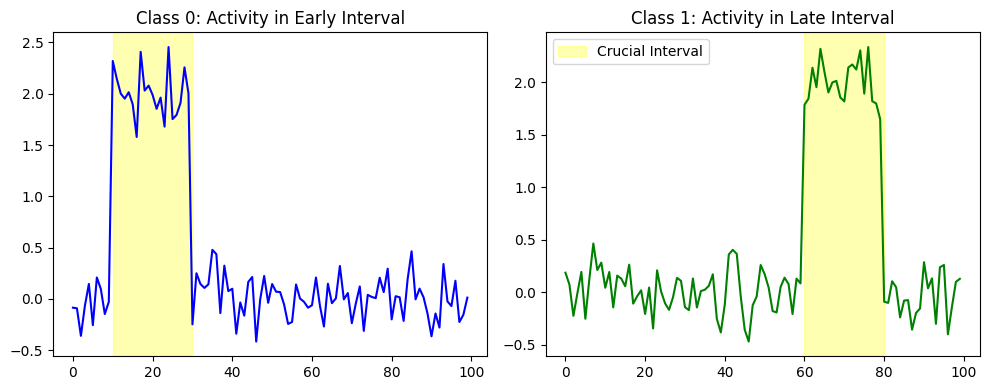

Interpretation: The TSF learned that high 'Mean' values in the [10-30] interval indicate Class 0,
while high 'Mean' values in the [60-80] interval indicate Class 1.


: 

In [ ]:
# Requires: pip install sktime numpy matplotlib scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.metrics import accuracy_score

# --- 1. GENERATE DATA (Location matters!) ---
# Class 0: Pulse occurs EARLY (Index 10-30)
# Class 1: Pulse occurs LATE (Index 60-80)
# Note: The "Shape" is identical (a pulse), only the "Interval" changes.
# This is where Interval-based methods shine.

n_samples = 50
time_steps = 100
X = np.zeros((n_samples, 1, time_steps)) # sktime expects (N, Dim, T)
y = np.zeros(n_samples)

for i in range(n_samples):
    # Base noise
    series = np.random.normal(0, 0.2, time_steps)
    
    if i < n_samples // 2:
        # Class 0: Early Pulse
        series[10:30] += 2.0
        y[i] = 0
    else:
        # Class 1: Late Pulse
        series[60:80] += 2.0
        y[i] = 1
        
    X[i, 0, :] = series

# --- 2. TRAIN TIME SERIES FOREST ---
# TSF will generate random intervals and calculate Mean, Std, Slope for each.
clf = TimeSeriesForestClassifier(n_estimators=50, random_state=42)
clf.fit(X, y)

# --- 3. VISUALIZATION OF LOGIC ---
# Let's verify accuracy
y_pred = clf.predict(X)
print(f"Model Accuracy: {accuracy_score(y, y_pred):.2f}")

# Visualize the two classes
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(X[0].ravel(), color='blue')
plt.title("Class 0: Activity in Early Interval")
plt.axvspan(10, 30, color='yellow', alpha=0.3, label="Crucial Interval")

plt.subplot(1, 2, 2)
plt.plot(X[-1].ravel(), color='green')
plt.title("Class 1: Activity in Late Interval")
plt.axvspan(60, 80, color='yellow', alpha=0.3, label="Crucial Interval")

plt.legend()
plt.tight_layout()
plt.show()

print("Interpretation: The TSF learned that high 'Mean' values in the [10-30] interval indicate Class 0,")
print("while high 'Mean' values in the [60-80] interval indicate Class 1.")



#### *End of Interval-based method* 
---

### Deep learning


#### 1. How it works
Deep Learning attempts to mimic the human brain's neural structure to learn patterns directly from raw data.


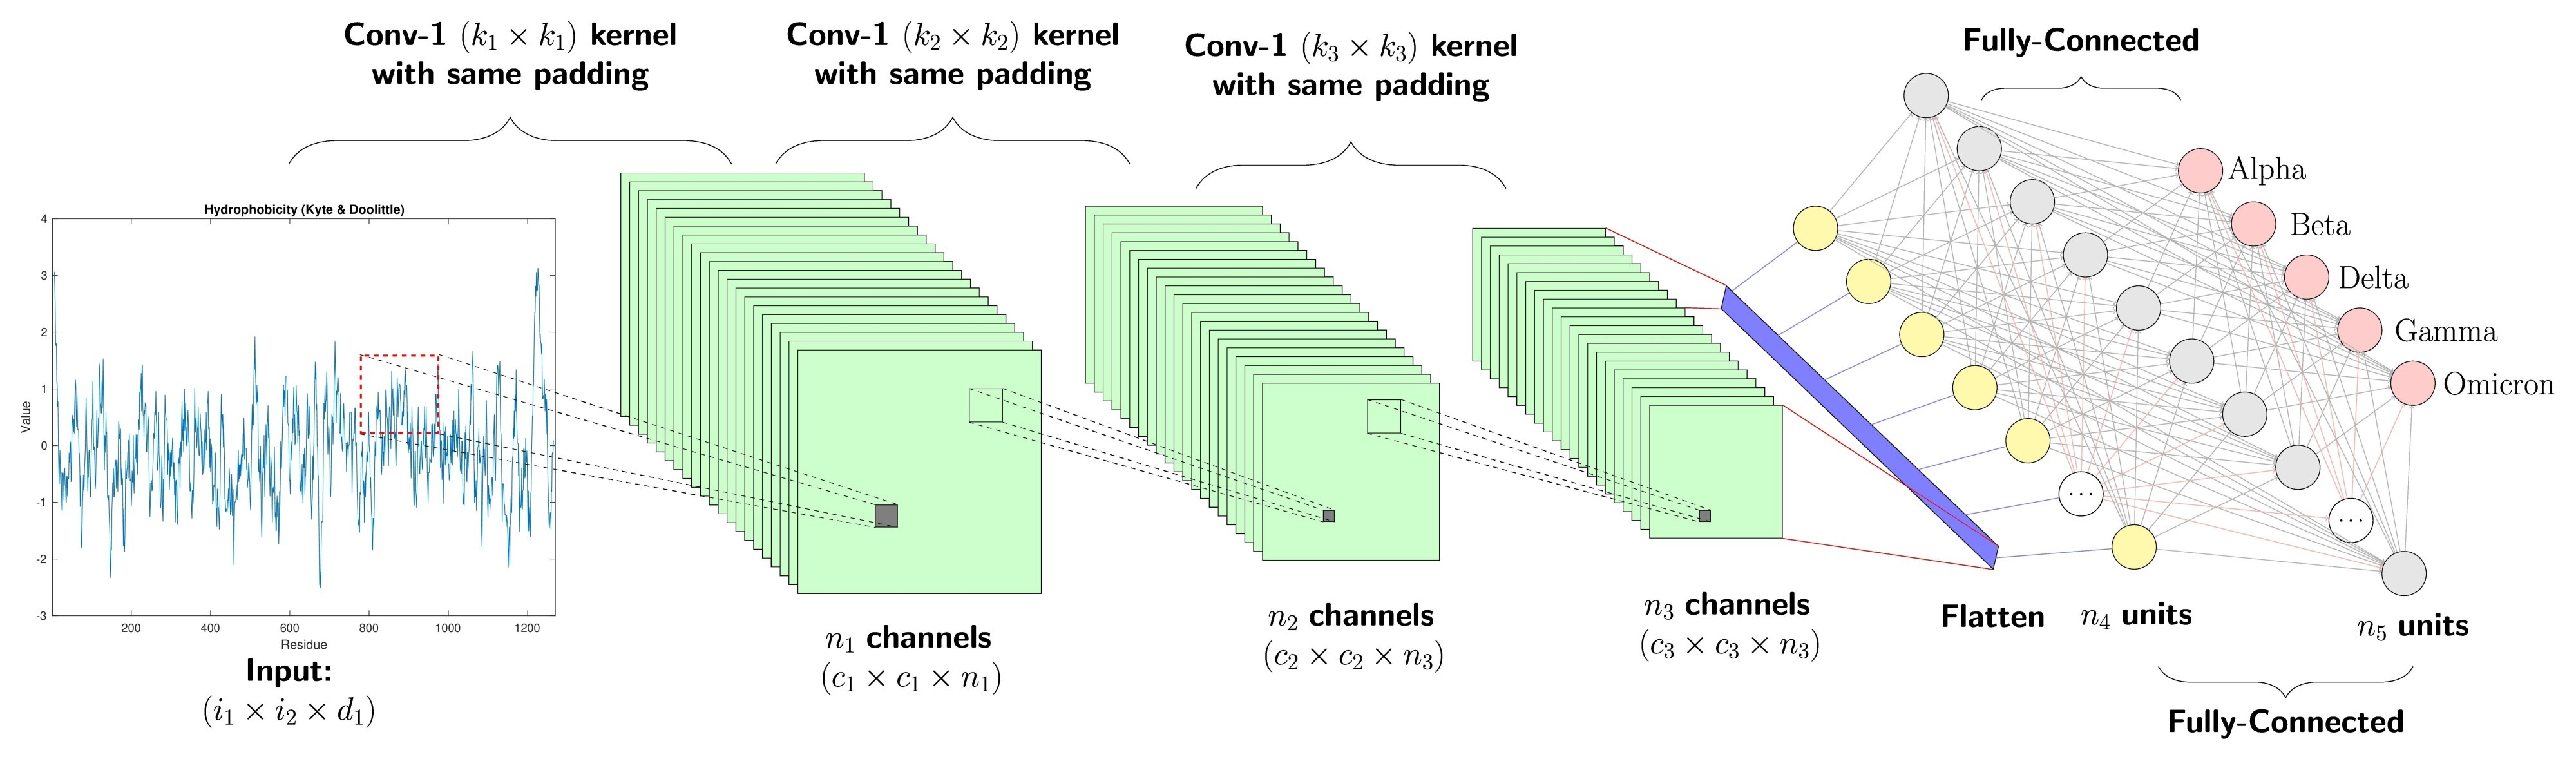

1.  **Input:** The raw time series data is fed into the network.
2.  **Hidden Layers (The "Deep" part):** The data passes through multiple layers of "neurons."
    * **Initial Layers:** These act like feature detectors for **fundamental shapes** (e.g., simple upward slopes, sharp spikes).
    * **Latter Layers:** These combine the simple shapes to form **complex representations** (e.g., a "heartbeat" cycle or a specific gesture pattern).
3.  **Classification:** The final layer receives this high-level abstract representation and assigns a probability to each class (e.g., 90% Class A, 10% Class B).


#### 2. Note
* **End-to-End Learning:** Unlike other methods where you might manually choose features (like "mean" in Interval-based) or lengths (like "20" in Shapelets), Deep Learning **automatically learns** what features are important.
* **Complexity:** These models have thousands or millions of parameters (weights) that need to be tuned during training.
* **Speed:** While training can take time, modern Deep Learning is often **orders of magnitude faster** than massive ensembles like HIVE-COTE, especially on large datasets.



#### 3. Why it is special
* **Hierarchical Feature Extraction:** It learns in a hierarchy. It builds complex concepts out of simple blocks.
* **State-of-the-Art Potential:** While it initially lagged behind language/image processing, Deep Learning (specifically architectures like ResNet and InceptionTime) is now catching up and often beating traditional algorithms on large benchmarks (UCR/UEA archives).
* **Raw Data In, Answer Out:** It minimizes the need for human domain expertise to "engineer" features.



#### 4. Example
**Human Activity Recognition (Accelerometer Data):**
* **Input:** A signal from a sensor on a runner's wrist.
* **Layer 1:** Detects small vertical vibrations.
* **Layer 2:** Combines vibrations to detect a rhythmic "step" pattern.
* **Layer 3:** Recognizes that the "step" frequency matches the pattern of "Running" rather than "Walking."
* **Output:** Classifies as "Running."



#### 5. Practical tips and pitfalls
* **Pitfall (Data Hunger):** Deep Learning models are "data-hungry." If you have a small dataset (e.g., 50 samples), the model will likely memorize the data (**Overfitting**) rather than learning general patterns. Use KNN or ROCKET for small data.
* **Pitfall (Black Box):** It is very hard to interpret *why* a Neural Network made a decision. (Unlike Shapelets where you can see the graph).
* **Tip (Normalization):** Neural Networks fail if data is not scaled. Always apply Z-normalization or MinMax scaling.
* **Tip (Architecture):** For Time Series, **1D-CNNs** (Convolutional Neural Networks) are usually better and faster than RNNs/LSTMs.



#### 6. When to choose
1.  **Large Datasets:** When you have thousands of training samples.
2.  **Complex Data:** When the relationship between the data and the class is highly non-linear and difficult to describe with simple statistics.
3.  **Raw Data:** When you don't know what features (shapes, frequencies, intervals) are important and want the machine to figure it out.

#### 7. Runnable Example

In [1]:
%pip install tensorflow numpy matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Training Neural Network...


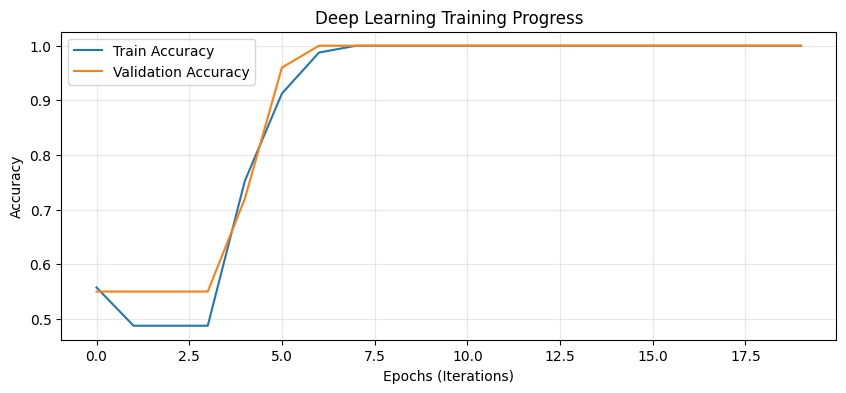

Final Model Accuracy: 1.00
Note: The model learned to distinguish Sine vs. Square waves automatically.


In [8]:
# Requires: pip install tensorflow numpy matplotlib scikit-learn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import layers, models

# --- 1. GENERATE SYNTHETIC DATA ---
# Class 0: Sine wave
# Class 1: Square wave (approximated)
# Deep Learning thrives on raw shape differences.
n_samples = 500 # Deep Learning needs more data!
time_steps = 100

X = np.zeros((n_samples, time_steps))
y = np.zeros(n_samples)

for i in range(n_samples):
    # Add random noise
    noise = np.random.normal(0, 0.2, time_steps)
    if i < n_samples // 2:
        # Class 0: Sine
        X[i, :] = np.sin(np.linspace(0, 4*np.pi, time_steps)) + noise
        y[i] = 0
    else:
        # Class 1: Square-ish wave (using sign of sine)
        X[i, :] = np.sign(np.sin(np.linspace(0, 4*np.pi, time_steps))) + noise
        y[i] = 1

# Shuffle data
X, y = shuffle(X, y, random_state=42)

# Reshape for Keras: (Samples, Time Steps, Channels)
X = X.reshape((n_samples, time_steps, 1))

# --- 2. BUILD DEEP LEARNING MODEL (1D-CNN) ---
model = models.Sequential([
    # Layer 1: Learn 16 "filters" (fundamental shapes)
    layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    layers.MaxPooling1D(pool_size=2),
    
    # Layer 2: Learn complex combinations
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(), # Summarize features
    
    # Final Layer: Classify
    layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification (0 or 1)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 3. TRAIN THE MODEL ---
print("Training Neural Network...")
history = model.fit(X, y, epochs=20, batch_size=16, validation_split=0.2, verbose=0)

# --- 4. VISUALIZATION ---
# Plot Accuracy over time
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deep Learning Training Progress')
plt.xlabel('Epochs (Iterations)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate
loss, acc = model.evaluate(X, y, verbose=0)
print(f"Final Model Accuracy: {acc:.2f}")
print("Note: The model learned to distinguish Sine vs. Square waves automatically.")



#### *End of Deep Learning method* 
---

## Libraries & tools

- Python:
  - `sktime` — unified framework for time series ML (classification, forecasting)
  - `tslearn` — algorithms and utilities (DTW, KMeans, classifiers)
  - `pyts` — transforms and classifiers for TSC
  - `tsfresh` — automated feature extraction
  - `sktime-dl` / `aeon` — deep learning helpers
- Research & datasets:
  - UCR / UEA time series archive (benchmark datasets)
- Useful packages:
  - `scikit-learn`, `pandas`, `numpy`, `torch` / `tensorflow` for DL

---

## Quick setup (Python)

Create a virtual environment and install common packages:

In [5]:
%pip install numpy matplotlib scikit-learn pandas
%pip install tslearn    # For DTW, Shapelets
%pip install sktime     # For ROCKET, Time Series Forest
%pip install tensorflow # For Deep Learning

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [7]:
# ==========================================
# 0. QUICK SETUP & IMPORTS
# ==========================================
# Run this cell first to ensure all libraries are installed and loaded.

# 1. Install necessary libraries (Uncomment if running in Colab/VirtualEnv)
# %pip install numpy matplotlib scikit-learn pandas
# %pip install tslearn    # For DTW, Shapelets
# %pip install sktime     # For ROCKET, Time Series Forest
# %pip install tensorflow # For Deep Learning

print("Checking library installations...")
print("...")

# 2. Import Common Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# 3. Configuration
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore') 
# Set random seed for reproducibility across all examples
np.random.seed(42) 
import tensorflow as tf
tf.random.set_seed(42)

print("✅ Environment Setup Complete!")
print(f"NumPy Version: {np.__version__}")
print(f"TensorFlow Version: {tf.__version__}")

Checking library installations...
...
✅ Environment Setup Complete!
NumPy Version: 2.3.4
TensorFlow Version: 2.20.0


---

## 🗺️ Note & Learning Path: Time Series Classification

This notebook documents the journey through various algorithms for Time Series Classification (TSC), ranging from traditional distance-based methods to modern Deep Learning approaches.

### 🧭 Quick Decision Guide

| Method | Analysis Scope | Speed (Train) | Speed (Predict) | Interpretability | Best Use Case |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **KNN-DTW** | **Whole Series (Global)** | Fast (Lazy) | Slow | ⭐⭐⭐ | Small data, Phase shifts over the entire series. |
| **Shapelets** | **Subsequences (Local)** | Slow | Fast | ⭐⭐⭐⭐⭐ | "Finding a needle in a haystack". Focuses only on the matching part. |
| **ROCKET** | **Subsequences (Kernels)** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐ | Fast baseline. Scans for patterns anywhere in the series. |
| **TS Forest** | **Intervals (Local)** | Fast | Fast | ⭐⭐⭐ | Features tied to specific time windows (e.g., "morning" vs "evening"). |
| **Deep Learning**| **Whole Series (End-to-End)**| Slow | Fast | ⭐⭐ | Massive data. Learns from raw input automatically. |
| **HIVE-COTE** | **Hybrid (All Types)** | **Very Slow** | **Slow** | ⭐⭐ | **Maximum Accuracy**. Combines Global, Local, and Frequency views. |

* **Whole Series (Global):**
    * **Mechanism:** Compares the entire sequence length from start to finish (End-to-End).
    * **Characteristic:** Global shape and overall trends are paramount. Every data point contributes to the classification.
    * **Examples:** *KNN-DTW, Deep Learning (CNNs).*

* **Subsequences (Local - Pattern-based):**
    * **Mechanism:** Uses sliding windows or kernels to scan for discriminative patterns, regardless of their position.
    * **Characteristic:** Focuses on the **existence** of a specific feature (e.g., a "bump" or "signature") and effectively ignores background noise.
    * **Examples:** *Shapelets, ROCKET.*

* **Intervals (Local - Time-based):**
    * **Mechanism:** Splits the series into specific time segments (intervals).
    * **Characteristic:** Focuses on **when** an event occurs (location-dependent statistics like mean/std of a specific interval).
    * **Examples:** *Time Series Forest.*

* **Hybrid:**
    * **Mechanism:** Combines all the above perspectives (Global, Shapelet, Frequency, Interval) to maximize accuracy.
    * **Examples:** *HIVE-COTE.*


---

## 🔗 References & Resources

#### 🛠️ Libraries Documentation
* **tslearn:** [https://tslearn.readthedocs.io/](https://tslearn.readthedocs.io/) 
    * *Used for: DTW, Soft-DTW, Learning Shapelets.*
* **sktime:** [https://www.sktime.net/](https://www.sktime.net/)
    * *Used for: ROCKET, Time Series Forest, HIVE-COTE.*
* **TensorFlow/Keras:** [https://www.tensorflow.org/](https://www.tensorflow.org/)
    * *Used for: Building 1D-CNNs.*

#### 📂 Datasets
* **UCR Time Series Classification Archive:** [https://dau.cs.ucr.edu/UCR_Archive/](https://dau.cs.ucr.edu/UCR_Archive/)
    * *The standard benchmark repository containing 128+ datasets (ECG, Sensors, Motion, etc.) to practice on.*

#### 📖 Key Papers (For Deep Dive)
* *DTW:* "Dynamic programming algorithm optimization for spoken word recognition" (Sakoe & Chiba).
* *Shapelets:* "Time Series Shapelets: A New Primitive for Data Mining" (Ye & Keogh).
* *ROCKET:* "ROCKET: Exceptionally fast and accurate time series classification using random convolutional kernels" (Dempster et al.).
* *Deep Learning:* "Deep learning for time series classification: a review" (Fawaz et al.).

---

© 2025 hwHoai | [github.com/hwHoai](https://github.com/hwHoai) | License: MIT